In [1]:
import torch
from torchvision import datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader as DataLoader
from torchvision import transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import glob
from google.colab import drive
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import cv2
import copy
import torchvision.transforms.functional as TF
import random
import math
import pandas as pd
from torchvision.utils import save_image

In [2]:
drive.mount('/content/drive/')
!pwd

Mounted at /content/drive/
/content


In [3]:
class img_dataset(Dataset):
  def __init__(self, kind='train', transforms=False, center_crop=False):
    self.center_crop = center_crop
    self.transforms = transforms
    self.kind = kind
    super(Dataset,self).__init__()
    path_kind = 'drive/MyDrive/hippocampus/' + kind
    self.features = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY) for file in glob.glob(path_kind+'/Total/*.jpg')]
    self.targets = [cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2GRAY) for file in glob.glob(path_kind+'/label/*.jpg')]
    assert len(self.features) == len(self.targets), "Something wrong with the dataset"

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    feature, target = self.features[index], self.targets[index]
    feature_tensor = torch.tensor(feature)
    feature_tensor = torch.unsqueeze(feature_tensor/255, 0)
    target_tensor = torch.tensor(target)/255
    target_tensor = torch.round(target_tensor)
    target_tensor = torch.unsqueeze(target_tensor, 0)
    if self.center_crop:
      feature_tensor = TF.center_crop(feature_tensor, 150)
      target_tensor = TF.center_crop(target_tensor, 150)
    if self.transforms:
      if self.kind == 'train' or self.kind == 'balanced_train':
        if random.uniform(0,1) > 0.8:
                x_unif = random.uniform(0.5, 1.5)
                feature_tensor = TF.adjust_gamma(feature_tensor, x_unif)
        if random.uniform(0,1) > 0.8:
                x1 = np.random.binomial(4, 0.5) - 2
                y1 = np.random.binomial(4, 0.5) - 2
                x2 = random.uniform(0.9, 1.1)
                x3 = random.uniform(-5, 5)
                feature_tensor = TF.affine(feature_tensor, angle=0, translate = [x1, y1], scale = x2, shear=x3)
                target_tensor = TF.affine(target_tensor, angle=0, translate = [x1, y1], scale = x2, shear=x3) # think it's needed because of shear (?)
        if random.uniform(0,1) > 0.8:
                feature_tensor = TF.gaussian_blur(feature_tensor, 3)
    return feature_tensor, target_tensor

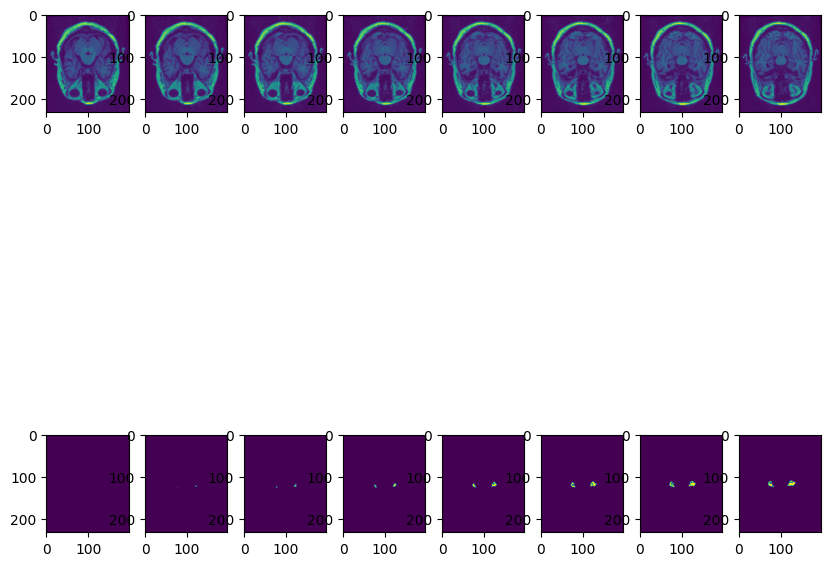

In [8]:
# Example features and targets
val_dataloader = DataLoader(img_dataset(kind='validation'), batch_size=8, shuffle=False)
u = 0
for validation_features, validation_targets in val_dataloader:
    u+=1
    if u==14:
          break
figure,axis = plt.subplots(2,8,figsize=(10,10))
for i in range(8):
  axis[0,i].imshow(torch.squeeze(validation_features[i], 0).numpy())
  axis[1,i].imshow(torch.squeeze(validation_targets[i], 0).numpy())

In [9]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels, batchnorm=False):
    super(DoubleConv, self).__init__()
    self.batchnorm = batchnorm
    if self.batchnorm:
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=True),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
        )
    else:
        self.conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=True),
        nn.ReLU(inplace=True)
        )

  def forward(self, x):
    return self.conv(x)

def init_xavier(model, retrain_seed):
  torch.manual_seed(retrain_seed)
  def init_weights(m):
    if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
      g = nn.init.calculta_gain('tanh')
      torch.nn.init.xavier_uniform_(m.weight, gain=g)
      m.bias.data.fill_(0)
  model.apply(init_weights)

class UNet(nn.Module):
  def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], batchnorm=False, initialization=False):
    super(UNet, self).__init__()
    self.batchnorm = batchnorm
    self.initialization = initialization
    self.name = f'UNet_batchnorm_{self.batchnorm}_initialization_{self.initialization}'
    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Down part of UNet
    for feature in features:
      self.downs.append(DoubleConv(in_channels, feature, batchnorm=self.batchnorm))
      in_channels = feature

    # Up part of UNet
    for feature in reversed(features):
      self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)) #feature*2 because of concatination
      self.ups.append(DoubleConv(feature*2, feature, batchnorm=self.batchnorm))

    # Bottleneck
    self.bottleneck = DoubleConv(features[-1], features[-1]*2, batchnorm=self.batchnorm)

    # Final Conv
    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.downs:
      x = down(x)
      skip_connections.append(x) # first has highest resolution
      x = self.pool(x)

    x = self.bottleneck(x)
    skip_connections = skip_connections[::-1]

    for i in range(0, len(self.ups), 2):
      x = self.ups[i](x) #ConvTranspose
      skip_connection = skip_connections[i//2]
      if x.shape != skip_connection.shape:
        x = transforms.functional.resize(x, skip_connection.shape[2:]) #ignoring batch size and channel size
      concat_skip = torch.concat((skip_connection, x), dim=1) #dim=1 is channel dimension
      x = self.ups[i+1](concat_skip) # DoubleConv

    return self.final_conv(x)

In [14]:
s = nn.Sigmoid()
class diceloss(nn.Module):
  def __init__(self):
    super(diceloss, self).__init__()
  def forward(self, outcome, label):
    return 1-(2*(s(outcome)*label).sum()+ 1e-5) / ((s(outcome)+label).sum()+ 1e-8)

In [10]:
def batch_loss(outputs, labels, batch_size, criterion): #gives empty_loss and nempty_loss for batch
  loss_empty_labels = []
  loss_not_empty_labels = []
  for i in range(batch_size):
    if torch.sum(labels[i]) == 0:
      loss_empty_labels.append(criterion(outputs[i].detach(), labels[i]).item())
    else:
      loss_not_empty_labels.append(criterion(outputs[i].detach(), labels[i]).item())
  return loss_empty_labels, loss_not_empty_labels

In [11]:
def train(p_trdata, transforms, model, criterion, epochs, seed, crop=False, balanced=False): #epochs = tuple
  # make dataloaders
  print('train')
  if not balanced:
    tr_dataset = img_dataset(kind='train', transforms=transforms, center_crop=crop)
  else:
    tr_dataset = img_dataset(kind='balanced_train', transforms=transforms, center_crop=crop)
  if p_trdata != 1:
      keep = math.floor(len(tr_dataset)*p_trdata)
      tr_dataset, _ = random_split(tr_dataset, [keep, len(tr_dataset)-keep], generator=torch.Generator().manual_seed(seed))
  print(len(tr_dataset))
  tr_dataloader = DataLoader(tr_dataset, batch_size=8, shuffle=True)
  del tr_dataset
  print('val')
  val_dataset = img_dataset(kind='validation', transforms=False, center_crop=crop)
  val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
  del val_dataset

  print('initialization')
  if model.initialization == True:
    init_xavier(model, seed)
  s = nn.Sigmoid() # for image saving

  # make folder
  print('make folders')
  full_model_name = f'{model.name}_transforms_{transforms}_criterion_{criterion}_ptrdata_{p_trdata}_seed_{seed}_crop_{crop}_balanced_{balanced}'
  path = 'drive/MyDrive/models/'+full_model_name
  if not os.path.isdir(path):
    os.mkdir(path)

  # train
  epochs_tr_empty_loss = []
  epochs_tr_nempty_loss = []
  epochs_tr_total_loss = []
  epochs_val_empty_loss = []
  epochs_val_nempty_loss = []
  epochs_val_total_loss = []
  min_val_loss = float("inf")
  start_epoch, end_epoch = epochs
  for epoch in range(start_epoch, end_epoch):
    print(epoch)
    empty_loss = []
    nempty_loss = []
    total_loss = []
    model.train()
    for i, data in enumerate(tr_dataloader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        el, nel = batch_loss(outputs, labels, outputs.shape[0], criterion)
        empty_loss.extend(el)
        nempty_loss.extend(nel)
        total_loss.append(loss.item())

        loss.backward()
        optimizer.step()

    # track training error once per epoch
    epochs_tr_empty_loss.append(np.mean(np.array(empty_loss)))
    epochs_tr_nempty_loss.append(np.mean(np.array(nempty_loss)))
    epochs_tr_total_loss.append(np.mean(np.array(total_loss)))

    # track validation error once per epoch
    model.eval()
    val_empty_loss = []
    val_nempty_loss = []
    val_total_loss = []
    with torch.no_grad():
        for i, data in enumerate(val_dataloader):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            vel, vnel = batch_loss(outputs, labels, outputs.shape[0], criterion)
            vloss = criterion(outputs, labels).item()
            val_empty_loss.extend(vel)
            val_nempty_loss.extend(vnel)
            val_total_loss.append(vloss)
    epochs_val_empty_loss.append(round(np.mean(np.array(val_empty_loss)), 5))
    epochs_val_nempty_loss.append(round(np.mean(np.array(val_nempty_loss)), 5))
    epochs_val_total_loss.append(round(np.mean(np.array(val_total_loss)), 5))

    # save model state if its better than the others
    if np.mean(np.array(val_total_loss)) < min_val_loss:
      torch.save(model.state_dict(), path+'/model.pth')
      min_val_loss = np.mean(np.array(val_total_loss))

    # save a predicted image once per epoch
    if epoch == start_epoch:
      u = 0
      for validation_features, validation_targets in val_dataloader:
          u+=1
          if u==14:
                break
      validation_features = validation_features.to(device)
      save_image(validation_targets[4], path+'/validation_target_nonempty.png')
      save_image(validation_features[4], path+'/validation_feature_nonempty.png')
      save_image(validation_targets[0], path+'/validation_target_empty.png')
      save_image(validation_features[0], path+'/validation_feature_empty.png')
      del validation_targets
    image_name_nempty = f'/validation_notempty_prediction_{epoch}.png'
    image_name_empty = f'/validation_empty_prediction_{epoch}.png'
    predictions = s(model(validation_features))
    save_image(predictions[4], path+image_name_nempty)
    save_image(predictions[0], path+image_name_empty)


  # save training and validation errors as csv
  d = {}
  d['tr_empty'] = epochs_tr_empty_loss
  d['tr_not_empty'] = epochs_tr_nempty_loss
  d['tr_total'] = epochs_tr_total_loss
  d['val_empty'] = epochs_val_empty_loss
  d['val_not_empty'] = epochs_val_nempty_loss
  d['val_total'] = epochs_val_total_loss
  df = pd.DataFrame(d)
  df.to_csv(path+f'/losses_start{start_epoch}.txt')

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
# criterion, optimizer, model => call train function
dice = diceloss()
bce = nn.BCEWithLogitsLoss()
model = UNet(batchnorm = True, initialization = True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
model.to(device)
train(p_trdata = 0.2, transforms = False, model = model, criterion = dice, epochs = (0,10), crop=False, balanced=True, seed = 1234)


train
1193
val
initialization
make folders
0


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


1
2
3
4
5
6
7
8
9
